In [1]:
from google.colab import drive
drive.mount('/content/drive')   

MessageError: ignored

Import tensorflow and other libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Use pandas to creat a dataframe

In [ ]:
dataframe=pd.read_csv('/content/drive/My Drive/unconventional oil and gas/OG_Compliance.csv')

In [ ]:
dataframe['Inspection year']=[i.split('/')[-1] for i in dataframe['INSPECTION_DATE']]

In [ ]:
dataframe.head()

,OPERATOR,INSPECTION_ID,INSPECTION_DATE,INSPECTION_TYPE,API_PERMIT,FARM_NAME,UNCONVENTIONAL,SITE_ID,SITE_NAME,FACILITY_TYPE,...,ENFORCEMENT_ID,ENFORCEMENT_CODE_DESCRIPTION,DATE_EXECUTED,ENFORCEMENT_FINAL_DATE,ENFORCEMENT_FINAL_STATUS,PENALTY_FINAL_DATE,PENALTY_FINAL_STATUS_CODE_DESCRIPTION,PENALTY_AMOUNT,TOTAL_AMOUNT_COLLECTED,Inspection year
0,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,239235.0,CACP - Consent Assessment of Civil Penalty,10/20/2008,10/20/2008,Comply/Closed,10/20/2008,COMP - Completed,"$8,400","$8,400",2008
1,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008
2,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008
3,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,239235.0,CACP - Consent Assessment of Civil Penalty,10/20/2008,10/20/2008,Comply/Closed,10/20/2008,COMP - Completed,"$8,400","$8,400",2008
4,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008


In [ ]:
dataframe['Inspection year'].value_counts()

2018    19690
2019    19618
2017    16866
2016    15562
2015    13513
2012    13173
2013    12782
2014    11818
2011    11274
2010     6121
2009     2934
2008     1396
2007      205
2006       99
2005       45
2004       26
2003       24
2002       10
2001        4
2000        2
Name: Inspection year, dtype: int64

In [ ]:
#清理数据 去除inspection comment 为空的行，去重,只保留原始comment长句大于10个字符的entries
dataframe=dataframe.dropna(subset=['INSPECTION_COMMENT'])
dataframe=dataframe.drop_duplicates(subset=['INSPECTION_COMMENT'])
dataframe=dataframe[dataframe['INSPECTION_COMMENT'].map(len)>50]
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42941 entries, 10 to 145161
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OPERATOR                               42941 non-null  object 
 1   INSPECTION_ID                          42941 non-null  int64  
 2   INSPECTION_DATE                        42941 non-null  object 
 3   INSPECTION_TYPE                        42941 non-null  object 
 4   API_PERMIT                             42941 non-null  object 
 5   FARM_NAME                              42941 non-null  object 
 6   UNCONVENTIONAL                         42941 non-null  object 
 7   SITE_ID                                42941 non-null  int64  
 8   SITE_NAME                              42941 non-null  object 
 9   FACILITY_TYPE                          42941 non-null  object 
 10  INSPECTION_CATEGORY                    42941 non-null  object 
 11  

In [ ]:
#创建两个数据库，分别只包含正例与反例
df_positives=dataframe[dataframe["VIOLATION_ID"].isna()==False]
df_negatives=dataframe[dataframe["VIOLATION_ID"].isna()==True]
print('positive examples',df_positives.shape)
print('negative examples',df_negatives.shape)

positive examples (2065, 36)
negative examples (40876, 36)


In [ ]:
#随机过采样5次增加正例数据
positive_1=df_positives.sample(2000)
positive_2=df_positives.sample(2000)
positive_3=df_positives.sample(2000)
positive_4=df_positives.sample(2000)
positive_5=df_positives.sample(2000)


po_df=pd.concat([positive_1,positive_2,positive_3,positive_4,positive_5],
                   ignore_index=True)
po_df.shape

(10000, 36)

In [ ]:
#拼接两个训练集 打乱顺序
from sklearn.utils import shuffle
dataframe=po_df.append(df_negatives)
dataframe=shuffle(dataframe)
dataframe.shape

(50876, 36)

In [ ]:
dataframe['if']=dataframe["VIOLATION_ID"].where(dataframe["VIOLATION_ID"]>0)

In [ ]:
dataframe['if']=dataframe['if'].isna()

In [ ]:
dataframe['if']

37764     True
25483     True
72379     True
89530     True
19105     True
         ...  
81675     True
60730     True
10430     True
72990     True
4728     False
Name: if, Length: 50876, dtype: bool

In [ ]:
# 0 代表没有发生违规 1 代表发生了违规
dataframe['if']=dataframe['if'].replace([True,False],[0,1])

In [ ]:
# 利用if 形成掩码数组
mask_array=dataframe['if'].values
mask_array.shape

(50876,)

In [ ]:
#mask 为 0， 删除没有发生违规的事项，即包含违规事项的掩码
#mask=1, 删除发生违规的事项，即包含没有违规的事项
import numpy.ma as ma

mask_violation=ma.masked_values(mask_array,0)
mask_violation=mask_violation.mask
mask_noviolation=ma.masked_values(mask_array,1)
mask_noviolation=mask_noviolation.mask

三层模型对应三个不同数据库。

In [ ]:
# 第一个数据库 从检查评论看是否发生违规事件
dataframe_idtf=dataframe[['Inspection year','INSPECTION_COMMENT','OPERATOR','SITE_ID','COUNTY','if']]
dataframe_idtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50876 entries, 37764 to 4728
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Inspection year     50876 non-null  object
 1   INSPECTION_COMMENT  50876 non-null  object
 2   OPERATOR            50876 non-null  object
 3   SITE_ID             50876 non-null  int64 
 4   COUNTY              50876 non-null  object
 5   if                  50876 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


# 1 第一个数据库

In [ ]:
#导入必要的库
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

# 创建inspection comment dataset，大小为（100337，714）

In [ ]:
inspec_idtf=dataframe_idtf['INSPECTION_COMMENT'].values

In [ ]:
inspec_idtf

array(['Chevron contracted Nabors to plug well.  Packer set at 1380 feet. Well was flushed to 1700 feet.  A total of 100 sack of Class A was used to cement well to surface',
       'Inspection for Inactive Well Status.  Cellar is empty.  5 1/2 X 9 5/8" annulus has 300 - 320 psi ( 2 guages).  9 5/8 X 13 3/8" annulus is vented w/ 0 % methane.',
       '4 wells on location - 2 top-holed , and 2 in production. Wells are clearly labelled. Available annuli were monitored for combustible gas. No combustible gas was detected. Altair 5X gas meter calibrated 9/19/17).',
       ...,
       "Well drilling complete.  Not fracced yet.  All wells completed on site.  H&P rig set up over well.  observed bubbling in cellar approximately 2' from well on outside of conductor.   Steady stream of small bubbling.  Also appears to be minor bubbling near cellar wall (west side).  H&P rig in process of being rigged down and moved off location.  Reserve pit being pumped down.",
       'Weather was 23° and cloudy

In [ ]:
#将 inspection comment 进行preprocessing 处理，表示为sentence_seq
def pre_sentence(features):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(features)
  tokenizer_config=tokenizer.get_config()
  #保存字典以便后面画图
  word_counts=json.loads(tokenizer_config['word_counts'])
  index_word=json.loads(tokenizer_config['index_word'])
  word_index=json.loads(tokenizer_config['word_index'])

  #map the sentences to tokens
  sentence_seq=tokenizer.texts_to_sequences(features)

  return word_counts,index_word,word_index,sentence_seq

In [ ]:
ins_word,ins_iw,ins_wi,inspec_seq=pre_sentence(inspec_idtf)

In [ ]:
len(ins_word)

39308

In [ ]:
#确定维度最高为128维
pre_idtf_ins=pad_sequences(inspec_seq,padding='post',maxlen=128)

In [ ]:
pre_idtf_ins.shape

(50876, 128)

In [ ]:
ins_np=np.array(pre_idtf_ins)
ins_np.shape

(50876, 128)

# 创建label dataset

In [ ]:
#构建label的dataset
label_df=dataframe_idtf['if'].values

In [ ]:
label_df

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
len(label_df)

50876

In [ ]:
label_np=np.array(label_df)
label_np.shape

(50876,)

# 创建couty dataset 大小为（100337，）

outputmode=tf-idf

In [ ]:
#构建一个只包含category attribute的dataframe
county=dataframe_idtf['COUNTY'].values
county

array(['Cambria', 'Wyoming', 'Lycoming', ..., 'Susquehanna', 'Lycoming',
       'Armstrong'], dtype=object)

In [ ]:
# 构建attribute dataset
county_vocab=dataframe_idtf["COUNTY"].value_counts()
county_vocab=county_vocab.index
county_vocab

Index(['Susquehanna', 'Washington', 'Bradford', 'Greene', 'Lycoming', 'Tioga',
       'Westmoreland', 'Fayette', 'Armstrong', 'Wyoming', 'Allegheny',
       'Sullivan', 'Potter', 'Butler', 'Beaver', 'Clearfield', 'Indiana',
       'Clinton', 'Somerset', 'Cameron', 'Centre', 'Elk', 'Jefferson',
       'Cambria', 'Clarion', 'Lawrence', 'McKean', 'Mercer', 'Blair', 'Forest',
       'Wayne', 'Warren', 'Columbia', 'Venango', 'Lackawanna', 'Huntingdon',
       'Bedford', 'Luzerne', 'Crawford', 'Erie'],
      dtype='object')

In [ ]:
len(county_vocab)

40

In [ ]:
layer1=preprocessing.StringLookup()
layer1.adapt(county)

In [ ]:
layer1.get_vocabulary()

['[UNK]',
 'Susquehanna',
 'Washington',
 'Bradford',
 'Greene',
 'Lycoming',
 'Tioga',
 'Westmoreland',
 'Fayette',
 'Armstrong',
 'Wyoming',
 'Allegheny',
 'Sullivan',
 'Potter',
 'Butler',
 'Beaver',
 'Clearfield',
 'Indiana',
 'Clinton',
 'Somerset',
 'Cameron',
 'Centre',
 'Elk',
 'Jefferson',
 'Cambria',
 'Clarion',
 'Lawrence',
 'McKean',
 'Mercer',
 'Blair',
 'Forest',
 'Wayne',
 'Warren',
 'Columbia',
 'Venango',
 'Lackawanna',
 'Luzerne',
 'Huntingdon',
 'Bedford',
 'Crawford',
 'Erie']

In [ ]:
layer1(county)

<tf.Tensor: shape=(50876,), dtype=int64, numpy=array([24, 10,  5, ...,  1,  5,  9])>

In [ ]:
county_cate=layer1(county)

In [ ]:
county_np=np.array(county_cate)
county_np=county_np.reshape(-1,1)
county_np.shape

(50876, 1)

In [ ]:
county_np

array([[24],
       [10],
       [ 5],
       ...,
       [ 1],
       [ 5],
       [ 9]])

# 创建SITE_ID dataset 使用cate embedding 的形式




In [ ]:
site_id=dataframe_idtf['SITE_ID'].values
site_id[:3]

array([739006, 741379, 775481])

In [ ]:
layer_site=preprocessing.IntegerLookup()
layer_site.adapt(site_id)
layer_site.get_vocabulary()

[-1,
 742198,
 816699,
 734718,
 733756,
 753289,
 729466,
 722723,
 751923,
 816401,
 764892,
 783869,
 759959,
 814645,
 763587,
 781204,
 751897,
 778936,
 732761,
 763105,
 791446,
 755171,
 786108,
 750439,
 739303,
 782885,
 761190,
 740459,
 820712,
 809495,
 734172,
 730685,
 738950,
 759255,
 726345,
 782701,
 766655,
 736560,
 734464,
 785960,
 710472,
 751715,
 747692,
 722747,
 749227,
 748852,
 748219,
 743594,
 715902,
 778780,
 768793,
 738425,
 736390,
 732718,
 739790,
 737163,
 812729,
 774702,
 751347,
 733483,
 820547,
 787709,
 730046,
 754022,
 812116,
 780719,
 759251,
 751215,
 818478,
 816352,
 756992,
 748221,
 714919,
 800619,
 759644,
 745326,
 810582,
 809665,
 783807,
 777526,
 756252,
 751789,
 811854,
 751831,
 739411,
 733567,
 810252,
 777334,
 754188,
 752636,
 737652,
 730619,
 717157,
 785466,
 782297,
 734264,
 787638,
 750080,
 745241,
 744430,
 738205,
 778333,
 778320,
 758813,
 823643,
 813518,
 789075,
 780047,
 741359,
 791818,
 782388,
 7794

In [ ]:
len(layer_site.get_vocabulary())

3607

In [ ]:
layer_site(site_id)

<tf.Tensor: shape=(50876,), dtype=int64, numpy=array([ 218, 1411,  250, ...,   91,  221,  882])>

In [ ]:
siteid_cat=layer_site(site_id)
siteid_np=np.array(siteid_cat)
siteid_np=siteid_np.reshape(-1,1)
siteid_np

array([[ 218],
       [1411],
       [ 250],
       ...,
       [  91],
       [ 221],
       [ 882]])

# 创建 Operator dataset categorical embedding

In [ ]:
operator=dataframe_idtf['OPERATOR'].values
operator

array(['CHEVRON APPALACHIA LLC', 'CHESAPEAKE APPALACHIA LLC',
       'INFLECTION ENERGY (PA) LLC', ..., 'CABOT OIL & GAS CORP',
       'INFLECTION ENERGY (PA) LLC', 'EXCO RESOURCES PA INC'],
      dtype=object)

In [ ]:
layer3=preprocessing.StringLookup()  
layer3.adapt(operator)
layer3.get_vocabulary()

['[UNK]',
 'CHESAPEAKE APPALACHIA LLC',
 'RANGE RESOURCES APPALACHIA LLC',
 'CABOT OIL & GAS CORP',
 'EQT PROD CO',
 'CHEVRON APPALACHIA LLC',
 'CHIEF OIL & GAS LLC',
 'SWN PROD CO LLC',
 'REPSOL OIL & GAS USA LLC',
 'SENECA RESOURCES CO LLC',
 'RICE DRILLING B LLC',
 'CNX GAS CO LLC',
 'XTO ENERGY INC',
 'SWEPI LP',
 'PENNENERGY RESOURCES LLC',
 'SNYDER BROS INC',
 'XPR RESOURCES LLC',
 'ATLAS RESOURCES LLC',
 'ARD OPR LLC',
 'CARRIZO (MARCELLUS) LLC',
 'SOUTHWESTERN ENERGY PROD CO',
 'EXCO RESOURCES PA LLC',
 'JKLM ENERGY LLC',
 'EOG RESOURCES INC',
 'INFLECTION ENERGY (PA) LLC',
 'ANADARKO E&P ONSHORE LLC',
 'PA GEN ENERGY CO LLC',
 'ROCKDALE MARCELLUS LLC',
 'VANTAGE ENERGY APPALACHIA II LLC',
 'ENERGY CORP OF AMER',
 'BKV OPR LLC',
 'MDS ENERGY LTD',
 'MDS ENERGY DEV LLC',
 'EAST RESOURCES INC',
 'ULTRA RESOURCES INC',
 'APEX ENERGY (PA) LLC',
 'CITRUS ENERGY CORP',
 'RE GAS DEV LLC',
 'DIVERSIFIED OIL & GAS LLC',
 'HILCORP ENERGY CO',
 'LPR ENERGY LLC',
 'EXCO RESOURCES PA INC',


In [ ]:
len(layer3.get_vocabulary())

135

In [ ]:
operator_cat=layer3(operator)
operator_np=np.array(operator_cat)
operator_np=operator_np.reshape(-1,1)
operator_np

array([[ 5],
       [ 1],
       [24],
       ...,
       [ 3],
       [24],
       [41]])

# 创建year category embedding 

In [ ]:
year=dataframe_idtf['Inspection year'].values.astype(int)
year

array([2015, 2013, 2017, ..., 2010, 2019, 2011])

In [ ]:
layer4=preprocessing.IntegerLookup()
layer4.adapt(year)
layer4.get_vocabulary()

[-1,
 2019,
 2018,
 2017,
 2016,
 2011,
 2012,
 2015,
 2013,
 2014,
 2010,
 2009,
 2008,
 2006,
 2007,
 2005,
 2003,
 2001,
 2004,
 2002,
 2000]

In [ ]:
len(layer4.get_vocabulary())

21

In [ ]:
year_cat=layer4(year)
year_np=np.array(year_cat)
year_np=year_np.reshape(-1,1)
year_np

array([[ 7],
       [ 8],
       [ 3],
       ...,
       [10],
       [ 1],
       [ 5]])

# 区分训练集、验证集、测试集

In [ ]:
#获取训练集与测试集 test
year_train,year_test,ins_train,ins_test,op_train,op_test,site_train,site_test,county_train,county_test,label_train,label_test=train_test_split(year_np,ins_np,operator_np,siteid_np,county_np,label_np,test_size=0.3,random_state=50)

In [ ]:
#查看数据条例
print(year_train.shape,"year_train")
print(year_test.shape,"year_test")

(35613, 1) year_train
(15263, 1) year_test


In [ ]:
mask_violation.shape

(50876,)

In [ ]:
# 创建两个集合
# 只包含 发生了违规事故
year_vio=ma.array(year_np,mask=mask_violation).compressed()
ins_vio=ma.array(ins_np,mask=mask_violation.repeat(128)).compressed()
ope_vio=ma.array(operator_np,mask=mask_violation).compressed()
site_vio=ma.array(siteid_np,mask=mask_violation).compressed()
county_vio=ma.array(county_np,mask=mask_violation).compressed()
label_vio=ma.array(label_np,mask=mask_violation).compressed()

# 只包含 没有发生违规事故
year_nov=ma.array(year_np,mask=mask_noviolation).compressed()
ins_nov=ma.array(ins_np,mask=mask_noviolation.repeat(128)).compressed()
ope_nov=ma.array(operator_np,mask=mask_noviolation).compressed()
site_nov=ma.array(siteid_np,mask=mask_noviolation).compressed()
county_nov=ma.array(county_np,mask=mask_noviolation).compressed()
label_nov=ma.array(label_np,mask=mask_noviolation).compressed()

In [ ]:
year_vio.shape

(10000,)

In [ ]:
year_nov.shape

(40876,)

In [ ]:
ins_vio=np.reshape(ins_vio,(-1,128))
ins_nov=np.reshape(ins_nov,(-1,128))

In [ ]:
#计算训练标签
import collections
collections.Counter(label_train)

Counter({0: 28558, 1: 7055})

In [ ]:
collections.Counter(label_test)

Counter({0: 12318, 1: 2945})

# 建立 identify model ——GRU


In [ ]:
from tensorflow.keras.layers import Embedding,Attention,GRU,Concatenate,Dense,Input,Flatten,LSTM,Bidirectional
from tensorflow.keras import Model

In [ ]:
a=np.random.rand(35613,1,4)

In [ ]:
a.shape

(35613, 1, 4)

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_i=GRU(128,activation='tanh')(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,128)

concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c]) #(batch,4,128)
contextv,output2=Attention()([e_o,concate],return_attention_scores=True)
output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)
output1=Flatten()(output1)

model=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1,output2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [ ]:
#确定 metrics
m1=tf.keras.metrics.BinaryAccuracy()

In [ ]:
#使用earlystopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_gru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model.compile(optimizer='adam',loss=['binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1],[]]) #两个输出

In [ ]:
history=model.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.3856 - flatten_loss: 0.3856 - flatten_binary_accuracy: 0.8320
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_gru/cp-01.ckpt
126/126 [==============================] - 102s 774ms/step - loss: 0.3856 - flatten_loss: 0.3856 - flatten_binary_accuracy: 0.8320 - val_loss: 0.2559 - val_flatten_loss: 0.2559 - val_flatten_binary_accuracy: 0.8846
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.2204 - flatten_loss: 0.2204 - flatten_binary_accuracy: 0.9009
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_gru/cp-02.ckpt
126/126 [==============================] - 97s 766ms/step - loss: 0.2204 - flatten_loss: 0.2204 - flatten_binary_accuracy: 0.9009 - val_loss: 0.2081 - val_flatten_loss: 0.2081 - val_flatten_binary_accuracy: 0.9048
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss:

In [ ]:
#制造虚拟目标
b=np.random.rand(18263,1,4)

In [ ]:
model.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_gru/cp-07.ckpt')

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru,_=model.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru,_=model.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.9705362138394411
********************
recall 0.970189346786346
********************
f1score 0.9703276431733893
********************
accuracy 0.970189346786346


In [ ]:
p,w=model.predict([year_train,ins_train,op_train,site_train,county_train])

In [ ]:
w.shape

(42613, 1, 4)

In [ ]:
#取 inspection, y s c 的 attention weights
ins_weights=w[:,:,0] # shape=(63211,1)
year_weights=w[:,:,1] # shape=(63211,1)
site_weights=w[:,:,2]
county_weights=w[:,:,3]

In [ ]:
#统计数值 ins_weights
#最小值
print('inspection min',np.min(ins_weights))
print('year min',np.min(year_weights))
print('site min',np.min(site_weights))
print('county min',np.min(county_weights))
#最大值
print('inspection max',np.max(ins_weights))
print('year max',np.max(year_weights))
print('site max',np.max(site_weights))
print('county max',np.max(county_weights))
#平均值
print('inspection mean',np.mean(ins_weights))
print('year mean',np.mean(year_weights))
print('site mean',np.mean(site_weights))
print('county mean',np.mean(county_weights))
#中值
print('inspection median',np.median(ins_weights))
print('year median',np.median(year_weights))
print('site median',np.median(site_weights))
print('county median',np.median(county_weights))
#标准差
print('inspection std',np.std(ins_weights))
print('year std',np.std(year_weights))
print('site std',np.std(site_weights))
print('county std',np.std(county_weights))

inspection min 8.2891405e-05
year min 0.0053322013
site min 0.005553529
county min 0.0069725714
inspection max 0.98214173
year max 0.80209047
site max 0.9707224
county max 0.4391635
inspection mean 0.2708241
year mean 0.21931742
site mean 0.30393627
county mean 0.20592214
inspection median 0.19872308
year median 0.23045495
site median 0.30060372
county median 0.21705483
inspection std 0.1777103
year std 0.062753335
site std 0.12474886
county std 0.058129545


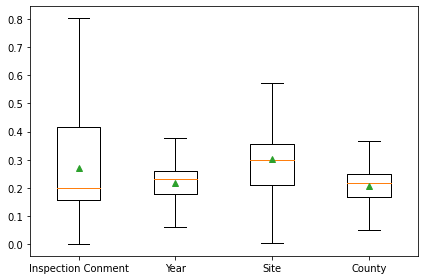

In [ ]:
#绘制attention 箱型图
import matplotlib.pyplot as plt

data=np.concatenate((ins_weights,year_weights,site_weights,county_weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Inspection Conment','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model1.png',dpi=500)

plt.show()

In [ ]:
#重新加载模型权重
#创建一个相同结构的model
#model=create_model()
#model.load_weights(checkpoint_path)

In [ ]:
#保存整个模型 以便后续分析
model.save('/content/drive/My Drive/unconventional oil and gas/model_identification.h5')

In [ ]:
#加载保存过的模型继续训练
new_model=tf.keras.models.load_model('/content/drive/My Drive/unconventional oil and gas/model_identification.h5')
#显示整个模型
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
new_model.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification')

In [ ]:
#在测试集上测试效果
new_model.evaluate(x=[year_test,ins_test,op_test,site_test,county_test],
               y=[label_test,b])

571/571 [==============================] - 19s 34ms/step - loss: 2.8996 - output_loss: 2.8996 - output_binary_accuracy: 0.7337 - output_auc: 0.5296 - output_precision: 0.6732 - output_recall: 0.3512


[2.8995521068573,
 2.8995521068573,
 0.7336691617965698,
 0.5295611619949341,
 0.6732321381568909,
 0.35118746757507324]

# 视觉展示不同结果的attention weights

In [ ]:
#没有发生违规事故的数据集 不要运行此段
year_nov=ma.array(year_np,mask=mask_noviolation).compressed()
ins_nov=ma.array(ins_np,mask=mask_noviolation).compressed()
ope_nov=ma.array(operator_np,mask=mask_noviolation).compressed()
site_nov=ma.array(siteid_np,mask=mask_noviolation).compressed()
county_nov=ma.array(county_np,mask=mask_noviolation).compressed()
label_nov=ma.array(label_np,mask=mask_noviolation).compressed()

In [ ]:
#所有样本的attentionweight
_,weight_all=model_bigru.predict([year_np,ins_np,operator_np,siteid_np,county_np])

In [ ]:
#取 inspection, y s c 的 attention weights
ins_weights=weight_all[:,:,0] 
year_weights=weight_all[:,:,1] 
site_weights=weight_all[:,:,2]
county_weights=weight_all[:,:,3]

In [ ]:
#统计数值 4 个维度
#最大值
print('ins max',np.amax(ins_weights))
print('year max',np.amax(year_weights))
print('site max',np.amax(site_weights))
print('county max',np.amax(county_weights))

#平均值
print('ins mean',np.mean(ins_weights))
print('year mean',np.mean(year_weights))
print('site mean',np.mean(site_weights))
print('county mean',np.mean(county_weights))

#中值
print('inspection median',np.median(ins_weights))
print('year median',np.median(year_weights))
print('site median',np.median(site_weights))
print('county median',np.median(county_weights))

#方差
print('ins var',np.var(ins_weights))
print('year var',np.var(year_weights))
print('site var',np.var(site_weights))
print('county var',np.var(county_weights))

ins max 0.7872322
year max 0.35245252
site max 0.6733151
county max 0.30409852
ins mean 0.28140923
year mean 0.23461759
site mean 0.25177073
county mean 0.23220244
inspection median 0.2800103
year median 0.23569281
site median 0.25098935
county median 0.23365583
ins var 0.0031621172
year var 0.0004291154
site var 0.00069641887
county var 0.00046880575


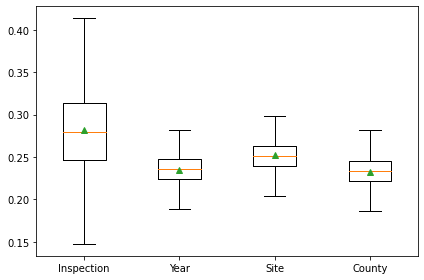

In [ ]:
#绘制attention 箱型图
import matplotlib.pyplot as plt

data=np.concatenate((ins_weights,year_weights,site_weights,county_weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model1_all.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合没有发生过违规事故的数据库
_,weight_nov=model_bigru.predict([year_nov,ins_nov,ope_nov,site_nov,county_nov])

#取 inspection, y s c 的 attention weights
ins_novweights=weight_nov[:,:,0] 
year_novweights=weight_nov[:,:,1] 
site_novweights=weight_nov[:,:,2]
county_novweights=weight_nov[:,:,3]

In [ ]:
#统计数值 4 个维度
#最大值
print('ins max',np.amax(ins_novweights))
print('year max',np.amax(year_novweights))
print('site max',np.amax(site_novweights))
print('county max',np.amax(county_novweights))

#平均值
print('ins mean',np.mean(ins_novweights))
print('year mean',np.mean(year_novweights))
print('site mean',np.mean(site_novweights))
print('county mean',np.mean(county_novweights))

#中值
print('inspection median',np.median(ins_novweights))
print('year median',np.median(year_novweights))
print('site median',np.median(site_novweights))
print('county median',np.median(county_novweights))

#方差
print('ins var',np.var(ins_novweights))
print('year var',np.var(year_novweights))
print('site var',np.var(site_novweights))
print('county var',np.var(county_novweights))

ins max 0.7872322
year max 0.35245252
site max 0.6733151
county max 0.30409852
ins mean 0.2712161
year mean 0.23712145
site mean 0.25628665
county mean 0.23537579
inspection median 0.2700264
year median 0.23872763
site median 0.25377393
county median 0.23707968
ins var 0.0025653678
year var 0.0003981041
site var 0.0005712761
county var 0.00043347265


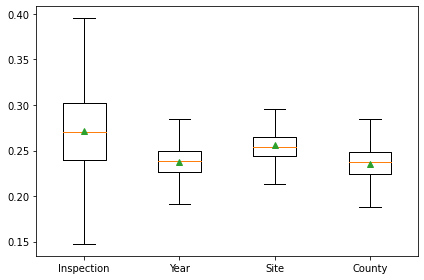

In [ ]:
#绘制attention 箱型图
import matplotlib.pyplot as plt

data=np.concatenate((ins_novweights,year_novweights,site_novweights,county_novweights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model1_noviolation.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合发生过违规事故的数据库
_,weight_vio=model_bigru.predict([year_vio,ins_vio,ope_vio,site_vio,county_vio])

#取 inspection, y s c 的 attention weights
ins_vioweights=weight_vio[:,:,0] 
year_vioweights=weight_vio[:,:,1] 
site_vioweights=weight_vio[:,:,2]
county_vioweights=weight_vio[:,:,3]

In [ ]:
#统计数值 4 个维度
#最大值
print('ins max',np.amax(ins_vioweights))
print('year max',np.amax(year_vioweights))
print('site max',np.amax(site_vioweights))
print('county max',np.amax(county_vioweights))

#平均值
print('ins mean',np.mean(ins_vioweights))
print('year mean',np.mean(year_vioweights))
print('site mean',np.mean(site_vioweights))
print('county mean',np.mean(county_vioweights))

#中值
print('inspection median',np.median(ins_vioweights))
print('year median',np.median(year_vioweights))
print('site median',np.median(site_vioweights))
print('county median',np.median(county_vioweights))

#方差
print('ins var',np.var(ins_vioweights))
print('year var',np.var(year_vioweights))
print('site var',np.var(site_vioweights))
print('county var',np.var(county_vioweights))

ins max 0.689708
year max 0.30687064
site max 0.4128948
county max 0.276806
ins mean 0.3230747
year mean 0.22438289
site mean 0.2333114
county mean 0.21923098
inspection median 0.31625456
year median 0.22644755
site median 0.23325877
county median 0.22262526
ins var 0.0034406749
year var 0.0004255015
site var 0.00078384427
county var 0.0004038117


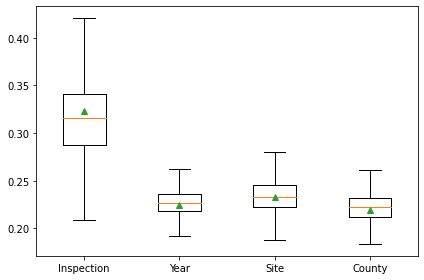

In [ ]:
#绘制attention 箱型图
import matplotlib.pyplot as plt

data=np.concatenate((ins_vioweights,year_vioweights,site_vioweights,county_vioweights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model1_violation.png',dpi=500)

plt.show()

# LSTM

In [ ]:
from tensorflow.keras.layers import Embedding,Attention,GRU,Concatenate,Dense,Input,LSTM,RNN,Bidirectional
from tensorflow.keras import Model

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_i=LSTM(128,activation='tanh')(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,128)

concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c]) #(batch,4,128)
contextv,output2=Attention()([e_o,concate],return_attention_scores=True)
output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)
output1=Flatten()(output1)

model_LSTM=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1,output2])

In [ ]:
model_LSTM.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_lstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_LSTM.compile(optimizer='adam',loss=['binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1],[]]) #两个输出

In [ ]:
model_LSTM.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.4009 - flatten_1_loss: 0.4009 - flatten_1_flatten_binary_accuracy: 0.8391
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_lstm/cp-01.ckpt
126/126 [==============================] - 118s 904ms/step - loss: 0.4009 - flatten_1_loss: 0.4009 - flatten_1_flatten_binary_accuracy: 0.8391 - val_loss: 0.2901 - val_flatten_1_loss: 0.2901 - val_flatten_1_flatten_binary_accuracy: 0.8669
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.2585 - flatten_1_loss: 0.2585 - flatten_1_flatten_binary_accuracy: 0.8800
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_lstm/cp-02.ckpt
126/126 [==============================] - 112s 889ms/step - loss: 0.2585 - flatten_1_loss: 0.2585 - flatten_1_flatten_binary_accuracy: 0.8800 - val_loss: 0.2540 - val_flatten_1_loss: 0.2540 - val_flatten_1_flatten_binary_accuracy: 0

In [ ]:
model_LSTM.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_lstm/cp-22.ckpt')

In [ ]:
prediction_gru,_=model_LSTM.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru,_=model_LSTM.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.9604199171596175
********************
recall 0.9593788901264496
********************
f1score 0.9597575848188762
********************
accuracy 0.9593788901264496


# BI-LSTM

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_i=Bidirectional(LSTM(128,activation='tanh'))(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,1,256)

concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c]) #(batch,4,256)
contextv,output2=Attention()([e_o,concate],return_attention_scores=True)
output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)
output1=Flatten()(output1)

model_bilstm=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1,output2])

In [ ]:
model_bilstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bilstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_bilstm.compile(optimizer='adam',loss=['binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1],[]]) #两个输出

In [ ]:
model_bilstm.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.1052 - flatten_2_loss: 0.1052 - flatten_2_flatten_1_flatten_binary_accuracy: 0.9607
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bilstm/cp-02.ckpt
126/126 [==============================] - 216s 2s/step - loss: 0.1052 - flatten_2_loss: 0.1052 - flatten_2_flatten_1_flatten_binary_accuracy: 0.9607 - val_loss: 0.1058 - val_flatten_2_loss: 0.1058 - val_flatten_2_flatten_1_flatten_binary_accuracy: 0.9621
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0552 - flatten_2_loss: 0.0552 - flatten_2_flatten_1_flatten_binary_accuracy: 0.9801
Epoch 3: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bilstm/cp-03.ckpt
126/126 [==============================] - 210s 2s/step - loss: 0.0552 - flatten_2_loss: 0.0552 - flatten_2_flatten_1_flatten_binary_accuracy: 0.9801 - val_loss: 0.0866 - val_flatten_2_loss: 0

In [ ]:
model_bilstm.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bilstm/cp-03.ckpt')


In [ ]:
prediction_bilstm,_=model_bilstm.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru,_=model_bilstm.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.97603904202163
********************
recall 0.9756928519950206
********************
f1score 0.975820355296689
********************
accuracy 0.9756928519950206


# BI-GRU

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_i=Bidirectional(GRU(128,activation='tanh'))(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,1,256)

concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c]) #(batch,4,256)
contextv,output2=Attention()([e_o,concate],return_attention_scores=True)
output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)
output1=Flatten()(output1)

model_bigru=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1,output2])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bigru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_bigru.compile(optimizer='adam',loss=['binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1],[]]) #两个输出

In [ ]:
model_bigru.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.3179 - flatten_3_loss: 0.3179 - flatten_3_flatten_2_flatten_1_flatten_binary_accuracy: 0.8780
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bigru/cp-01.ckpt
126/126 [==============================] - 195s 1s/step - loss: 0.3179 - flatten_3_loss: 0.3179 - flatten_3_flatten_2_flatten_1_flatten_binary_accuracy: 0.8780 - val_loss: 0.2176 - val_flatten_3_loss: 0.2176 - val_flatten_3_flatten_2_flatten_1_flatten_binary_accuracy: 0.9065
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.1237 - flatten_3_loss: 0.1237 - flatten_3_flatten_2_flatten_1_flatten_binary_accuracy: 0.9533
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bigru/cp-02.ckpt
126/126 [==============================] - 180s 1s/step - loss: 0.1237 - flatten_3_loss: 0.1237 - flatten_3_flatten_2_flatten_1_flatten_binary_accuracy: 0

In [ ]:
model_bigru.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_bigru/cp-07.ckpt')

In [ ]:
prediction_gru,_=model_bigru.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru,_=model_bigru.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)  
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.9822713373881332
********************
recall 0.9814584288802988
********************
f1score 0.9816603284290022
********************
accuracy 0.9814584288802988


# SVM


In [ ]:
from sklearn import svm,metrics
x=np.concatenate((year_train,ins_train,op_train,site_train,county_train),axis=1)
x.shape

(35613, 132)

In [ ]:
#合并input_x
x_test=np.concatenate((year_test,ins_test,op_test,site_test,county_test),axis=1)

In [ ]:
label_train.shape

(35613,)

In [ ]:
clf=svm.SVC()
clf.fit(x,label_train)

SVC()

In [ ]:
predicted_svm=clf.predict(x_test)

In [ ]:
# 指标
print('accuracy',accuracy_score(label_test,predicted_svm))
print('*********************************')
print('precision',precision_score(label_test,predicted_svm,average='weighted'))
print('*********************************')
print('recall',recall_score(label_test,predicted_svm,average='weighted'))
print('*********************************')
print('f1',f1_score(label_test,predicted_svm,average='weighted'))

accuracy 0.8629365131363428
*********************************
precision 0.8631664068447914
*********************************
recall 0.8629365131363428
*********************************
f1 0.840144364549494


# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf=RandomForestClassifier(max_depth=2,random_state=0)
clf_rf.fit(x,label_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
predicted_rf=clf_rf.predict(x_test)

In [ ]:
# 指标
print('accuracy',accuracy_score(label_test,predicted_rf))
print('*********************************')
print('precision',precision_score(label_test,predicted_rf,average='weighted'))
print('*********************************')
print('recall',recall_score(label_test,predicted_rf,average='weighted'))
print('*********************************')
print('f1',f1_score(label_test,predicted_rf,average='weighted'))

accuracy 0.800366900347245
*********************************
precision 0.6405871751714568
*********************************
recall 0.800366900347245
*********************************
f1 0.7116184762649255


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr=LogisticRegression(C=1e5).fit(x,label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
predicted_lr=clf_lr.predict(x_test)

In [ ]:
# 指标
print('accuracy',accuracy_score(label_test,predicted_lr))
print('*********************************')
print('precision',precision_score(label_test,predicted_lr,average='weighted'))
print('*********************************')
print('recall',recall_score(label_test,predicted_lr,average='weighted'))
print('*********************************')
print('f1',f1_score(label_test,predicted_lr,average='weighted'))

accuracy 0.7983358448535675
*********************************
precision 0.7393737725472138
*********************************
recall 0.7983358448535675
*********************************
f1 0.7322465219666782


# without attention GRU

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_i=GRU(128,activation='tanh')(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,128)

concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c,e_o]) #(batch,4,128)
concate=Flatten()(concate)
output1=Dense(128,activation='relu')(concate) #(batch,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)

model_wg=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
model_wg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutgru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_wg.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m1]) 

In [ ]:
model_wg.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8025
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutgru/cp-01.ckpt
126/126 [==============================] - 112s 838ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8025 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8049
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8027
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutgru/cp-02.ckpt
126/126 [==============================] - 94s 743ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8027 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8049
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8027
Epoch 3: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutgru/cp-03

In [ ]:
model_wg.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutgru/cp-01.ckpt')

In [ ]:
prediction_gru=model_wg.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wg.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.6447891132372644
********************
recall 0.8029876171132805
********************
f1score 0.7152451931640224
********************
accuracy 0.8029876171132805


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Without attention Bi-GRU

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_i=Bidirectional(GRU(128,activation='tanh'))(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,1,256)


concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c,e_o]) #(batch,4,128)
concate=Flatten()(concate)
output1=Dense(128,activation='relu')(concate) #(batch,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)

model_wbg=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
model_wbg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbigru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_wbg.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m1]) 

In [ ]:
model_wbg.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8028
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbigru/cp-01.ckpt
126/126 [==============================] - 195s 2s/step - loss: 0.0000e+00 - binary_accuracy: 0.8028 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8049
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8027
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbigru/cp-02.ckpt
126/126 [==============================] - 191s 2s/step - loss: 0.0000e+00 - binary_accuracy: 0.8027 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8049
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8027
Epoch 3: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbigru/cp-0

In [ ]:
model_wbg.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbigru/cp-01.ckpt')

In [ ]:
prediction_gru=model_wbg.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wbg.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.6475277390777436
********************
recall 0.8046910830112035
********************
f1score 0.7176050739911854
********************
accuracy 0.8046910830112035


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Without attention LSTM

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_i=LSTM(128,activation='tanh')(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,1,128)


concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c,e_o]) #(batch,4,128)
concate=Flatten()(concate)
output1=Dense(128,activation='relu')(concate) #(batch,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)

model_wlstm=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
model_wlstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutlstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_wlstm.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m1]) 

In [ ]:
model_wlstm.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train],
          callbacks=  [early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.7976
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutlstm/cp-01.ckpt
126/126 [==============================] - 129s 985ms/step - loss: 0.0000e+00 - binary_accuracy: 0.7976 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8071
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8013
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutlstm/cp-02.ckpt
126/126 [==============================] - 116s 921ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8013 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8071
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8013
Epoch 3: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutlstm/c

In [ ]:
model_wlstm.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutlstm/cp-01.ckpt')

In [ ]:
#测试inference时间
prediction_gru=model_wlstm.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wlstm.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.6456311492079541
********************
recall 0.8035117604664875
********************
f1score 0.7159710996738478
********************
accuracy 0.8035117604664875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Without attention bi-lstm

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_i=Input(shape=(128,)) #(batch,128)
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_i=Embedding(40000,128,name='inspection')(input_i) #(batch,128,128)


e_y=Embedding(23,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(142,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(3728,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(41,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_i=Bidirectional(LSTM(128,activation='tanh'))(e_i)
e_i=tf.expand_dims(e_i,1) #(batch,1,256)


concate=Concatenate(axis=1)([e_i,e_y,e_s,e_c,e_o]) #(batch,4,128)
concate=Flatten()(concate)
output1=Dense(128,activation='relu')(concate) #(batch,128)
output1=Dense(1,activation='sigmoid',name='output')(output1)

model_wbl=Model(inputs=[input_y,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbilstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_wbl.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m1]) 

In [ ]:
model_wbl.fit(x=[year_train,ins_train,op_train,site_train,county_train],y=[label_train],
          callbacks=  [early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8013
Epoch 1: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbilstm/cp-01.ckpt
126/126 [==============================] - 216s 2s/step - loss: 0.0000e+00 - binary_accuracy: 0.8013 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8071
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8013
Epoch 2: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbilstm/cp-02.ckpt
126/126 [==============================] - 208s 2s/step - loss: 0.0000e+00 - binary_accuracy: 0.8013 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.8071
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0000e+00 - binary_accuracy: 0.8013
Epoch 3: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbilstm/c

In [ ]:
model_wbl.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification_withoutbilstm/cp-01.ckpt')

In [ ]:
#测试运行时间
prediction_gru=model_wbl.predict(x=[year_test,ins_test,op_test,site_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wbl.predict(x=[year_test,ins_test,op_test,site_test,county_test])
prediction_gru=np.around(prediction_gru)
print('precision',precision_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(label_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(label_test,prediction_gru))

precision 0.6456311492079541
********************
recall 0.8035117604664875
********************
f1score 0.7159710996738478
********************
accuracy 0.8035117604664875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 存储词向量

In [ ]:
#存储词向量
# one contains the embedding labels(meta.tsv).
# one contain the embedding(vecs.csv)
import io
from os import path

out_v = io.open('drive/My Drive/Colab Notebook/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('drive/My Drive/Colab Notebook/meta.tsv', 'w', encoding='utf-8')

k = 0

for word, token in word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!